In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
inputs = np.array([[1,2,3,2.5],
                   [2.0,5.0,-1.0,2.0],
                   [-1.5,2.7,3.3,-0.8]])

weights = [[0.2,0.8,-0.5,1.0],
           [0.5,-0.91,0.26,-0.5],
           [-0.26,-0.27,0.17,0.87]]

biases = [2,3,0.5]

layer_output = np.dot(inputs, np.array(weights).T) + biases


weights2 = [[0.2,0.8,-0.5],
            [0.5,-0.91,0.26],
            [-0.26,-0.27,0.17]]

biases2 = [2,3,0.5]

layer_output2 = np.dot(layer_output, np.array(weights2).T) + biases2

print(layer_output2)

[[ 2.7355   4.919   -0.66925]
 [ 2.232    9.1491  -1.2913 ]
 [ 3.1098   2.75535 -0.14595]]


In [4]:
X = np.array([[1,2,3,2.5],
                   [2.0,5.0,-1.0,2.0],
                   [-1.5,2.7,3.3,-0.8]])

np.random.seed(0)

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights ) + self.biases
        return self.output

layer1 = Layer_Dense(4,5)
layer2 = Layer_Dense(5,6)

layer1 = layer1.forward(X)
layer2 = layer2.forward(layer1)
print(layer2)

[[-0.06635745 -0.07876527  0.10318969  0.11809888 -0.01409357  0.11115574]
 [-0.01154699 -0.04874198  0.00884775  0.07513459 -0.14256868  0.11875513]
 [ 0.13624801 -0.05087333  0.06957695  0.17383363 -0.04458113  0.03546162]]


In [5]:
!pip install nnfs

In [6]:
import nnfs
from nnfs.datasets import spiral_data


nnfs.init()

#X = np.array([[1,2,3,2.5],
                   #[2.0,5.0,-1.0,2.0],
                   #[-1.5,2.7,3.3,-0.8]])

X, y = spiral_data(100,3)

np.random.seed(0)

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights ) + self.biases
        return self.output

class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        return self.output

layer1 = Layer_Dense(2,5)
activation1 = Activation_ReLU()

layer1 = layer1.forward(X)
print(layer1)

activation1 = activation1.forward(layer1)
print(activation1)


[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [-4.1430970e-04  1.0363824e-03  1.4717819e-04  5.7170109e-04
   9.5552590e-04]
 [ 7.5134775e-04  1.9940494e-03  1.0251545e-03  2.7258496e-03
   3.0446041e-03]
 ...
 [-1.9087122e-01 -1.5524280e-02 -9.6635871e-02 -2.1548781e-01
  -1.6781661e-01]
 [-1.5870789e-01 -5.2860741e-02 -9.3678579e-02 -2.1798500e-01
  -1.8881387e-01]
 [-1.9889441e-01 -6.0513122e-03 -9.7320430e-02 -2.1471010e-01
  -1.6238230e-01]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.00103638 0.00014718 0.0005717  0.00095553]
 [0.00075135 0.00199405 0.00102515 0.00272585 0.0030446 ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [7]:
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

X, y = spiral_data(100,3)

np.random.seed(0)

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights ) + self.biases
        return self.output

class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        return self.output

class Activation_Softmax:
    def forward(self, inputs):
        exponantial = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        normalize = exponantial / np.sum(exponantial, axis=1, keepdims=True)
        self.output = normalize
        return self.output

layer1 = Layer_Dense(2,5)
relu1 = Activation_ReLU()
softmax1 = Activation_Softmax()

print("--------------------Layer--------------------")
layer1 = layer1.forward(X)
print(layer1)

print("--------------------ReLU--------------------")
relu1 = relu1.forward(layer1)
print(relu1)

print("--------------------Softmax--------------------")
softmax1 = softmax1.forward(layer1)
print(softmax1)


--------------------Layer--------------------
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [-4.1430970e-04  1.0363824e-03  1.4717819e-04  5.7170109e-04
   9.5552590e-04]
 [ 7.5134775e-04  1.9940494e-03  1.0251545e-03  2.7258496e-03
   3.0446041e-03]
 ...
 [-1.9087122e-01 -1.5524280e-02 -9.6635871e-02 -2.1548781e-01
  -1.6781661e-01]
 [-1.5870789e-01 -5.2860741e-02 -9.3678579e-02 -2.1798500e-01
  -1.8881387e-01]
 [-1.9889441e-01 -6.0513122e-03 -9.7320430e-02 -2.1471010e-01
  -1.6238230e-01]]
--------------------ReLU--------------------
[[0.         0.         0.         0.         0.        ]
 [0.         0.00103638 0.00014718 0.0005717  0.00095553]
 [0.00075135 0.00199405 0.00102515 0.00272585 0.0030446 ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
--------------------Softmax--------------------
[[0.2        0.2     

In [8]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss


class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(softmax1, y)

print("Loss:", loss)

Loss: 1.6029614


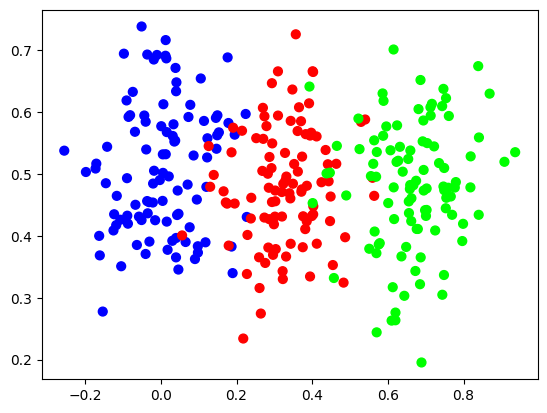

In [9]:
import matplotlib.pyplot  as  plt
import  nnfs 
from  nnfs.datasets  import  vertical_data

nnfs.init()

X, y  =  vertical_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg') 
plt.show() 

In [19]:
X, y = vertical_data(samples=100, classes=3)

dense_layer1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense_layer2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

loss_function = Loss_CategoricalCrossentropy()

lowest_loss = 9999999

best_dense_layer1_weights = dense_layer1.weights.copy()
best_dense_layer1_biases  = dense_layer1.biases.copy()
best_dense_layer2_weights = dense_layer2.weights.copy()
best_dense_layer2_biases  = dense_layer2.biases.copy()

for iteration in range(10000):

    # Mutate weights randomly
    dense_layer1.weights += 0.05 * np.random.randn(2, 3)
    dense_layer1.biases  += 0.05 * np.random.randn(1, 3)
    dense_layer2.weights += 0.05 * np.random.randn(3, 3)
    dense_layer2.biases  += 0.05 * np.random.randn(1, 3)

    # Forward pass
    dense_layer1.forward(X)
    activation1.forward(dense_layer1.output)
    dense_layer2.forward(activation1.output)
    activation2.forward(dense_layer2.output)

    loss = loss_function.calculate(activation2.output, y)

    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    # Check if improved
    if loss < lowest_loss:
        print(f'New best found at iteration {iteration}: loss={loss}, acc={accuracy}')

        best_dense_layer1_weights = dense_layer1.weights.copy()
        best_dense_layer1_biases  = dense_layer1.biases.copy()
        best_dense_layer2_weights = dense_layer2.weights.copy()
        best_dense_layer2_biases  = dense_layer2.biases.copy()

        lowest_loss = loss

    else:
        # Revert to best-known weights
        dense_layer1.weights = best_dense_layer1_weights.copy()
        dense_layer1.biases  = best_dense_layer1_biases.copy()
        dense_layer2.weights = best_dense_layer2_weights.copy()
        dense_layer2.biases  = best_dense_layer2_biases.copy()


New best found at iteration 0: loss=1.0981566905975342, acc=0.44333333333333336
New best found at iteration 5: loss=1.0979905128479004, acc=0.3333333333333333
New best found at iteration 6: loss=1.0966342687606812, acc=0.3333333333333333
New best found at iteration 9: loss=1.0929783582687378, acc=0.3333333333333333
New best found at iteration 10: loss=1.0899206399917603, acc=0.3333333333333333
New best found at iteration 11: loss=1.089300274848938, acc=0.3333333333333333
New best found at iteration 13: loss=1.0849310159683228, acc=0.6066666666666667
New best found at iteration 14: loss=1.0827674865722656, acc=0.5033333333333333
New best found at iteration 16: loss=1.0804412364959717, acc=0.49333333333333335
New best found at iteration 17: loss=1.0802735090255737, acc=0.3333333333333333
New best found at iteration 21: loss=1.0801547765731812, acc=0.3333333333333333
New best found at iteration 23: loss=1.0772737264633179, acc=0.4166666666666667
New best found at iteration 24: loss=1.0743